# Format Parks
This notebooks formats and begins to look at data from National and State parks with the goal of organizing their information into a netcdf file.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd

data_dir = "/pool0/home/steinadi/data/wa_drought/DatabaseDrafts"

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Good to go
# ----------
# pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,18), header=1, sheet_name="Recreation Visits", index_col=[0,1,2], usecols='B:Q')
# pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,20), header=1, sheet_name="Overnight", usecols='B:N', index_col=[0,1,2])

# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Overnight", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Total", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Day Use", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Day User Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Overnight Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)

# Needs splicing
# --------------
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Day Use", skiprows=np.arange(1,6), index_col=0, header=1) # some totals that I think can be cut out?
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Overnight", skiprows=np.arange(1,7), index_col=2, header=1) # also some strange totals

Load in files

In [3]:
nat_park_visits = pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,18), header=1, sheet_name="Recreation Visits", index_col=[1,2], usecols='B:Q')
# need to sort the index to better optimize things later
nat_park_visits = nat_park_visits.sort_index()
nat_park_overnight = pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,20), header=1, sheet_name="Overnight", usecols='B:N', index_col=[0,1,2])
# need to sort the index to better optimize things later
nat_park_overnight = nat_park_overnight.sort_index()

<AxesSubplot:>

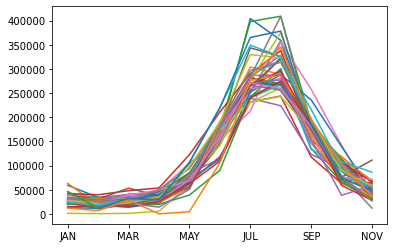

In [4]:
# do a plot just cause
nat_park_visits.loc["Mount Rainer National Park"][['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].transpose()[:-1].plot(legend=False)

In [5]:
# collect all given years and parks from both the daily and overnight
parks = []
years = []
for dex in nat_park_visits.index[:]:
    if dex[0] not in parks:
        parks.append(dex[0])
    if dex[1] not in years:
        years.append(int(dex[1]))
for dex in  nat_park_overnight.index:
    if dex[1] not in parks:
        parks.append(dex[1])
    if dex[2] not in years:
        years.append(dex[2])
print(parks)
# cut off the nan and All Years
years = years[:-2]
# sort years
years = sort(years)
print(years)

['Crater Lake', 'John Day Fossil Beds National Monument', 'Klondike Gold Rush National Recreation Area', 'Lake Chelan National Recreation Area', 'Lake Roosevelt National Recreation Area', 'Lewis and Clark National Historic Place', 'Mount Rainer National Park', 'North Cascades National Park', 'Olympic National Park', 'Oregon Caves National Park and National Monument', 'Ross Lake National Recreation Area', 'San Juan National Historic Park']
[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]


In [6]:
# also nab month names for manipulating the vists data
months=list(nat_park_visits.columns[1:-1])
print(months)

['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']


In [110]:
# Develop a new DataFrame so that we can have it as a timeseries
revised_nat_park_visits = pd.DataFrame(index=pd.date_range(start=f"{years[0]}", end=f'{years[-1]}', freq='MS'), columns=parks)
# collect where we throw errors
errors = []
for park in parks:
    for year in years:
        for month_num, month in enumerate(months):
            try:
                revised_nat_park_visits[park].loc[f'{year}-{month_num+1}-01'] = nat_park_visits.loc[park, year][month].values[0]
            except:
                errors.append((park, year, month))

# set types
for park in parks:
    revised_nat_park_visits[park] = revised_nat_park_visits[park].astype(float)

In [78]:
# did check, these errors are where there is no data, so we did things right above
# errors

In [111]:
# tada
revised_nat_park_visits

,Crater Lake,John Day Fossil Beds National Monument,Klondike Gold Rush National Recreation Area,Lake Chelan National Recreation Area,Lake Roosevelt National Recreation Area,Lewis and Clark National Historic Place,Mount Rainer National Park,North Cascades National Park,Olympic National Park,Oregon Caves National Park and National Monument,Ross Lake National Recreation Area,San Juan National Historic Park
1979-01-01,6771.0,295.0,0.0,NaN,2095.0,1498.0,24214.0,2556.0,48453.0,1158.0,NaN,6786.0
1979-02-01,5820.0,1886.0,0.0,NaN,2698.0,2809.0,15342.0,4350.0,38221.0,1142.0,NaN,4227.0
1979-03-01,10617.0,4978.0,0.0,NaN,13027.0,7088.0,40179.0,5465.0,75100.0,4617.0,NaN,6288.0
1979-04-01,11004.0,4829.0,0.0,NaN,30627.0,5547.0,43153.0,21066.0,105322.0,4815.0,NaN,5913.0
1979-05-01,21528.0,7883.0,0.0,NaN,73162.0,7406.0,65792.0,58174.0,130894.0,6806.0,NaN,6060.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,59093.0,9849.0,71.0,4589.0,134576.0,18737.0,195942.0,5023.0,334249.0,72.0,138272.0,55754.0
2020-10-01,61613.0,10050.0,331.0,2473.0,82377.0,18043.0,101916.0,1830.0,188318.0,624.0,127816.0,43146.0
2020-11-01,18270.0,3144.0,1368.0,1127.0,59911.0,12014.0,36523.0,18.0,107430.0,297.0,15950.0,31646.0
2020-12-01,26100.0,2663.0,0.0,1058.0,53923.0,8567.0,42198.0,2.0,80143.0,432.0,9040.0,36161.0


In [135]:
nat_park_visits_ds = xr.Dataset(
    coords = dict(
        time = revised_nat_park_visits.index,
        park = parks,
    ),
    data_vars=dict(
        day_visits=(["time","park"], revised_nat_park_visits.values)
    )
)
nat_park_visits_ds

<xarray.Dataset>
Dimensions:     (time: 505, park: 12)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
  * park        (park) <U48 'Crater Lake' ... 'San Juan National Historic Park'
Data variables:
    day_visits  (time, park) float64 6.771e+03 295.0 0.0 ... 7.184e+03 2.612e+04

Success!! Did double check that I didn't transpose it weird and we good. Going to save this first version.

In [136]:
nat_park_visits_ds.to_netcdf('/pool0/home/steinadi/data/wa_drought/wa_drought/Data/national_parks_v1.nc')

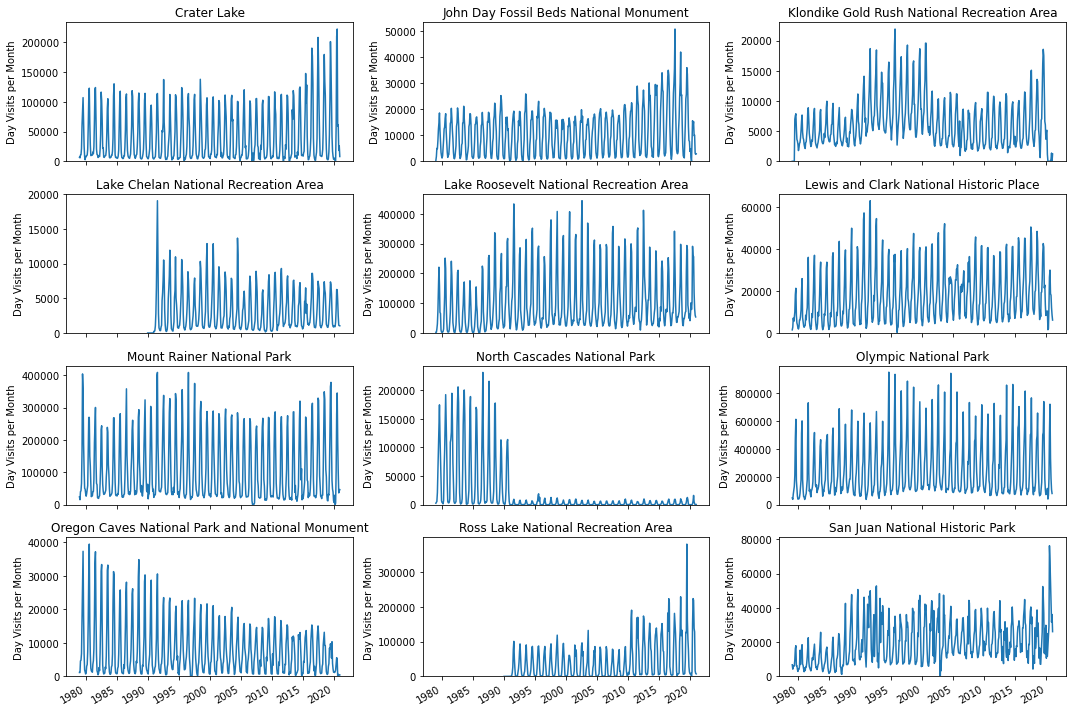

In [149]:
fig, axs = plt.subplots(4,3, figsize=(15,10), sharex=True)
ax_all = axs.ravel()

for ax, park in zip(ax_all, parks):
    nat_park_visits_ds['day_visits'].sel(park=park).plot(ax=ax)
    ax.set_title(park)
    ax.set_ylabel('Day Visits per Month')
    ax.set_xlabel('')
    ax.set_ylim(0,ax.get_ylim()[1])

plt.tight_layout()

In [140]:
np.where(nat_park_visits_ds.isel(park=11)['day_visits'].values<0)

(array([286]),)

In [141]:
nat_park_visits_ds.isel(park=11)['day_visits'].values[286]

-20331.0

In [142]:
nat_park_visits_ds.isel(park=11)['time'].values[286]

numpy.datetime64('2002-11-01T00:00:00.000000000')

Lmao, found a fun typo in the original data. Did double check with the spreadsheet, I did not introduce it. Made a comment in the original spreadsheet, so will go ahead and fix it

Hm, we should check if there are any other negative values

In [143]:
for park in parks:
    print(park, np.where(nat_park_visits_ds.sel(park=park)['day_visits'].values<0))

Crater Lake (array([], dtype=int64),)
John Day Fossil Beds National Monument (array([], dtype=int64),)
Klondike Gold Rush National Recreation Area (array([], dtype=int64),)
Lake Chelan National Recreation Area (array([], dtype=int64),)
Lake Roosevelt National Recreation Area (array([], dtype=int64),)
Lewis and Clark National Historic Place (array([], dtype=int64),)
Mount Rainer National Park (array([], dtype=int64),)
North Cascades National Park (array([], dtype=int64),)
Olympic National Park (array([], dtype=int64),)
Oregon Caves National Park and National Monument (array([], dtype=int64),)
Ross Lake National Recreation Area (array([], dtype=int64),)
San Juan National Historic Park (array([286]),)


Cool cool, that was the only one.